# <span style="color:green"> Laboratorio di Simulazione Numerica (NSL) </span>
## <span style="color:blue">  Esercitazione 10 </span>

### Esercizio 10.1-10.2: Il Problema del Commesso Viaggiatore(TSP) - Calcolo Parallelo

### Obiettivo

In questa esercitazione l'obiettivo è di **parallellizzare** il codice C++, scritto nella precedente esercitazione, che risolve il problema **TSP** (un problema di complessità computazionale NP-hard) con un algoritmo genetico in modo da effettuare 5 ricerche genetiche parallelle del migliore percorso su $p=5$ processori differenti. Quindi, ogni **nodo**(processore) del calcolo esegue una ricerca **GA** indipendente, indicata con il nome **Continente**, ma, con l'accortezza, che ogni $N_{mig} = 10$ generazioni i continenti possano scambiarsi, casualmente, il loro migliore individuo (o appunto percorso).

Tale codice parallellizzato verrà applicato per risolvere il TSP di un insieme di città $N_{city} = 34$ distribuite casualmente all'interno di un quadrato di lato $l=2$ o su un cerchio di raggio $r=1$, come in *Ex 9.ipynb*. I risulati verrano mostrati in modo analogo agli precedenti esercizi, eventualmente confrontando le performance dei diversi approcci ed algoritmi impiegati per la risoluzione del medesimo problema e le performance dei vari processori (nodi).

L'ultima richiesta è quella di applicare il codice "parallelizzato" al dataset delle $N_{city} = 50$ capitali degli stati americani, di cui viene fornita latitudine e longitudine, per verificare le performance su un sistema più complesso.

### Parallel Computing e codice C++

Il calcolo *parallelo*, a differenza di quello standard *seriale*, permette spesso di risolvere lo stesso **task** computazionale in un tempo **ridotto**, elaborandolo in un numero $p$ (con $p > 1$) di processori (CPU), in cambio di uno sforzo di programmazione più impegnativo. 

Si potrebbe definire come la collezione di elelementi di calcolo in grado di **comunicare** e **cooperare** allo scopo di risolvere al più presto tasks computazionali di complessità crescente.

Tra i vari modelli presenti l'attenzione sarà focalizzata sul paradigma del **Message Program Passing(MPP)** e, in partcicolare, del **Single Program Multiple Data(SPMD)**, nel quale tutti i processori eseguono lo stesso programma (producendo lo stesso eseguibile) lavorando , eventualmente, con un insieme di dati differenti e  con la possibilità per i diversi nodi di comunicare e condividere tra loro i propri risultati parziali attraverso un network di interconnessione, non essendo disponibile uno spazio di reindirizzamento di memoria condiviso.

La parallellizzazione nel paradigma MPP viene realizzata sfruttando le librerie **Message Passing Interface (MPI)** (scambio di messaggi) che permettono di intervenire direttamente (e manualmente) sul codice in maniera fine e a basso livello servednosi delle relative funzionalità. 

Riassumendo: con MPI è possibile implementare modelli per il passaggio di messaggi tra le diverse CPU, coinvolte nel calcolo parallelo, consentendo di separare il task computazionale (il più possibile in modo *bilanciato*) in vari sottoprocessi e **sincronizzando** i risultati ottenuti pur **non** avendo uno *spazio di reindirizzamento di memoria* comune e **condiviso**.


Per rendere disponibili tutte le funzionalità di MPI nel codice C++ sono state inserite le seguenti funzioni:

1. #include "mpi.h": inclusione delle librerie come prerequisito.

2.  MPI_Init(...): genera l'inizializzazione delle librerie nell'ambiente MPI nel codice. Viene inserito all'inizio del programma.

3. MPI_Comm_size(MPI_COMM_WORLD, &size): ritorna il numero di processori (*int size*) coinvolti nella parallellizzazione e appartenenti al **comunicatore** *MPI_COMM_WORLD*, ossia un identificatore che rappresenta il gruppo dei processori(nodi) partecipanti.

4. MPI_Comm_rank(MPI_COMM_WORLD, &rank): per identificare ciascun processo appartenente al comunicatore *MPI_COMM_WORLD* con un unico e specifico valore intero, detto **rank**.

5. MPI_Finalize(): che finalizza il calcolo MPI.

Dato che in SPMD ogni nodo esegue lo stesso programma la variabile idenificativa rank servirà a differenziare il comportamento dei vari nodi coinvolti assegnando specifiche istruzioni.

Inoltre, come verrà approfondito in seguito, la comunicazione avviene mediante messaggi espliciti ed intervenendo manualmente sul codice fornendo le opportune istruzioni. Le subroutines di **Comunicazione Collettiva** e di **Comunicazione Punto a Punto** permettono lo scambio di informazioni e di dati (uni o bidirezionale) tra gruppi di nodi o tra singoli nodi.

Per risolvere il TSP il codice C++, già scritto e descritto nell'*esercitazione* 9, è stato parallellizzato (quindi arricchito dalla struttura preesistente) con i seguenti passaggi, oltre a quelli già descritti sopra: 

- Ciascun nodo legge dal file Primes (nella routine di inizializzazione *Input()*) una coppia di completamento del seme del generatore di numeri casuali differente in modo tale da differenziare le sequenze stocastiche che ogni nodo andrà a simulare ed elaborare. Se ogni nodo leggesse la stessa coppia le simulazioni e le sequenze che da esse ne derivano sarebbero completamente identiche realizzando la medesima simulazione in parallello e compromettendo qualsiasi possibilità di migliorare le performance (anzi).



- Si generano le coordinate delle $N_{city}$ da visitare e si costruisce l'individuo di partenza nel processore identificato dal $rank = 0$ e poi si trasferiscono i dati (le posizioni e le label delle città generate) ai 4 nodi rimanenti, copiandoli in opportuni vettori, rispettivamente di double(coordinate x,y) e di int(le label) e sfruttando la sottofunzione  MPI_Bcast(...) delle comunicazioni collettive. Quest'ultima implementa il trasporto di un "messaggio" da uno specifico nodo (detto radice) a tutti gli altri appartenenti allo stesso comunicatore dato in argomento. In questo modo ogni processore lavora con lo stesso insieme di città ricercando lo stesso percorso ottimale. Senza queste istruzioni, data la diversità del seme, ciascun processore avrebbe elaborato una simulazione a partire da configurazioni di città diverse e ricercando una soluzione ottimale corrispondente a un minimo della funzione costo differente (in pratica i nodi non starebbero più risolvendo lo stesso problema).



- Si costruisce la popolazione di partenza rimescolando casualmente l'ordine delle città nell'individuo di partenza (metodo *Shuffle()*). Per diversificare la popolazione iniziale in ogni processore viene ripetuto il mescolamento casuale un numero di volte pari al valore del rank associato +1 (quindi uno shuffle per il nodo identificato dal rank 0; 2 per il nodo con rank 1 e così via).



- Infine viene aggiunta la routine *Migration()* che ogni $N_{mig} = 10$ generazioni sulle $N_{gen} = 10^3$ totali realizza un numero di scambi casuale (pari a $N_{exchange} = size$) dei migliori individui  tra i **Continenti** sino a quel punto della simulazione. Lo scambio viene implementato servendosi delle subroutines **bloccanti** delle comunicazioni punto a punto. Per ogni scambio vengono selezionati casualmente due valori di rank associati ai rispettivi nodi, tra cui avverrà il flusso **bidirezionale** di informazioni (se sono diversi), e i dati da trasferire (ossia il migliore individuo finora esplorato), dopo averli copiati in opportuni vettori di double ed int,  vengono scambiati con le funzioni *MPI_Send(..)* e *MPI_Recv()*. La chiamata di queste ultime nei due rank selezionati viene eseguita, essenso bloccanti, in modo inverso per evitare di sovraccaricare il buffer di sistema e generare eventuali punti morti (**deadlock**).

Il resto del programma, così come i parametri di input, viene lasciato invariato, se non con l'aggiunta di qualche metodo nelle tre classi principali utile per agevolare il trasferimento dei dati.

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

def load_best_ev_data(Y_file):
    X, Y = np.loadtxt(Y_file, usecols=(0,1), unpack='true')
    return X,Y
    
def load_bestav_ev_data(Y_file):
    X,Y,Y_err = np.loadtxt(Y_file, usecols = (0,1,2), unpack='true')
    return X,Y,Y_err

def load_best_data(Y_file):
    X,Y = np.loadtxt(Y_file, usecols=(1,2), unpack='true')
    return X,Y
    
def plot_best_ev(ax , x, y ,lab ):
    ax.plot(x, y, label=lab)
    ax.set_title("The Best path throughtout generations" , fontsize = 20)
    ax.set_xlabel('generations', fontsize=15)
    ax.tick_params(axis='x', labelsize= 17)
    ax.tick_params(axis='y', labelsize= 17)
    ax.set_xscale("log")
    ax.set_ylabel('$L^{(1)}$', fontsize=15)
    ax.legend(loc="best", prop={'size': 15})
    ax.grid(True)
    
def plot_bestav_ev(ax , x, y, err, lab):
    ax.errorbar(x, y,  yerr = err , label = lab)
    ax.set_title("Averaged length on the best half of population throughtout generations", fontsize = 20)
    ax.set_xlabel('generations', fontsize=15)
    ax.tick_params(axis='x', labelsize= 17)
    ax.tick_params(axis='y', labelsize= 17)
    ax.set_xscale("log")
    ax.set_ylabel('$<L^{(1)}>$', fontsize=15)
    ax.legend(loc="best", prop={'size': 15})
    ax.grid(True)
    
def plot_best(ax , x ,y , shape):
    ax.plot(x,y,zorder=1,label = 'Percorso')
    
    if(shape == "Square"): 
        ax.add_patch(Rectangle((-1,-1), 2, 2, fill=False , linestyle='-.'))
    if(shape =="Circle"): 
        ax.add_patch(Circle((0, 0), 1, color='black', linestyle = '-.' , fill=False))
    if(shape == "AmericanCities"):
        img = plt.imread("usa.png")
        ax5.imshow(img, extent=[-157.5, -30, 15, 77.5])
    
    ax.scatter(x,y,zorder=2)
    ax.scatter(x[0],y[0],s=100,label ='Starting and returning city',color = 'r', zorder = 2)
    ax.scatter(x[1],y[1],label ='First visit',color = 'm',zorder = 2)
    ax.scatter(x[len(x)-1],y[len(y)-1],label ='Last visit',color = 'g',zorder = 2)
    ax.set_title('The Best absolutely path', fontsize = 20)
    ax.axis("equal")
    ax.tick_params(axis='x', labelsize= 17)
    ax.tick_params(axis='y', labelsize= 17)
    ax.set_xlabel("x", fontsize = 15)
    ax.set_ylabel("y", fontsize = 15)
    ax.legend(loc="best", prop={'size': 10})

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
nodes = np.arange(5)
filenames= ["Best_Individual_Evolution.dat" , "Average_Individuals_Evolution.dat" ,"Best_Individual.dat" , "Best_of_the_Best.dat"]

I risultati della simulazione ottenuta parallellizzando il codice con l'algoritmo genetico che risolve il problema TSP sono riportati nelle tre celle di seguito.
- Nei primi due grafici di ogni cella sono riportati gli andamenti nel corso delle generazioni della **funzione costo** e della **media** della stessa sulla parte migliore della popolazione per i vari nodi. Nel primo grafico è anche riportato l'andamento in funzione delle generazioni del percorso migliore in assoluto. Questi due grafici presentano scala logaritmica sull'asse delle ascisse. 
- Il terzo grafico confronta i risultati ottenuti per TSP dalla computazione **parallela** e quelli ottenuti da simulazioni a **core singolo**. La scala sull'asse delle ascisse è lineare. 
- Il quarto grafico in basso a sinistra mostra la distribuzione tra i vari nodi del **Best of the Best** (quante volte il *B.o.B.* appartiene a quello specifico nodo nel corso delle generazioni), ossia il migliore individuo tra tutti quelli presenti nelle popolazioni dei 5 nodi. Questo ci può aiutare a capire il reale contributo all'efficienza nella risoluzione di un problema del calcolo parallelo. 
- L'ultimo grafico infine mostra il **percorso migliore** tra le $N_{city}$ città (il *Best of the Best*) al termine della simulazione.

The best absolute path belongs to Node: 0.0
The best absolute path is 6.24867 long.


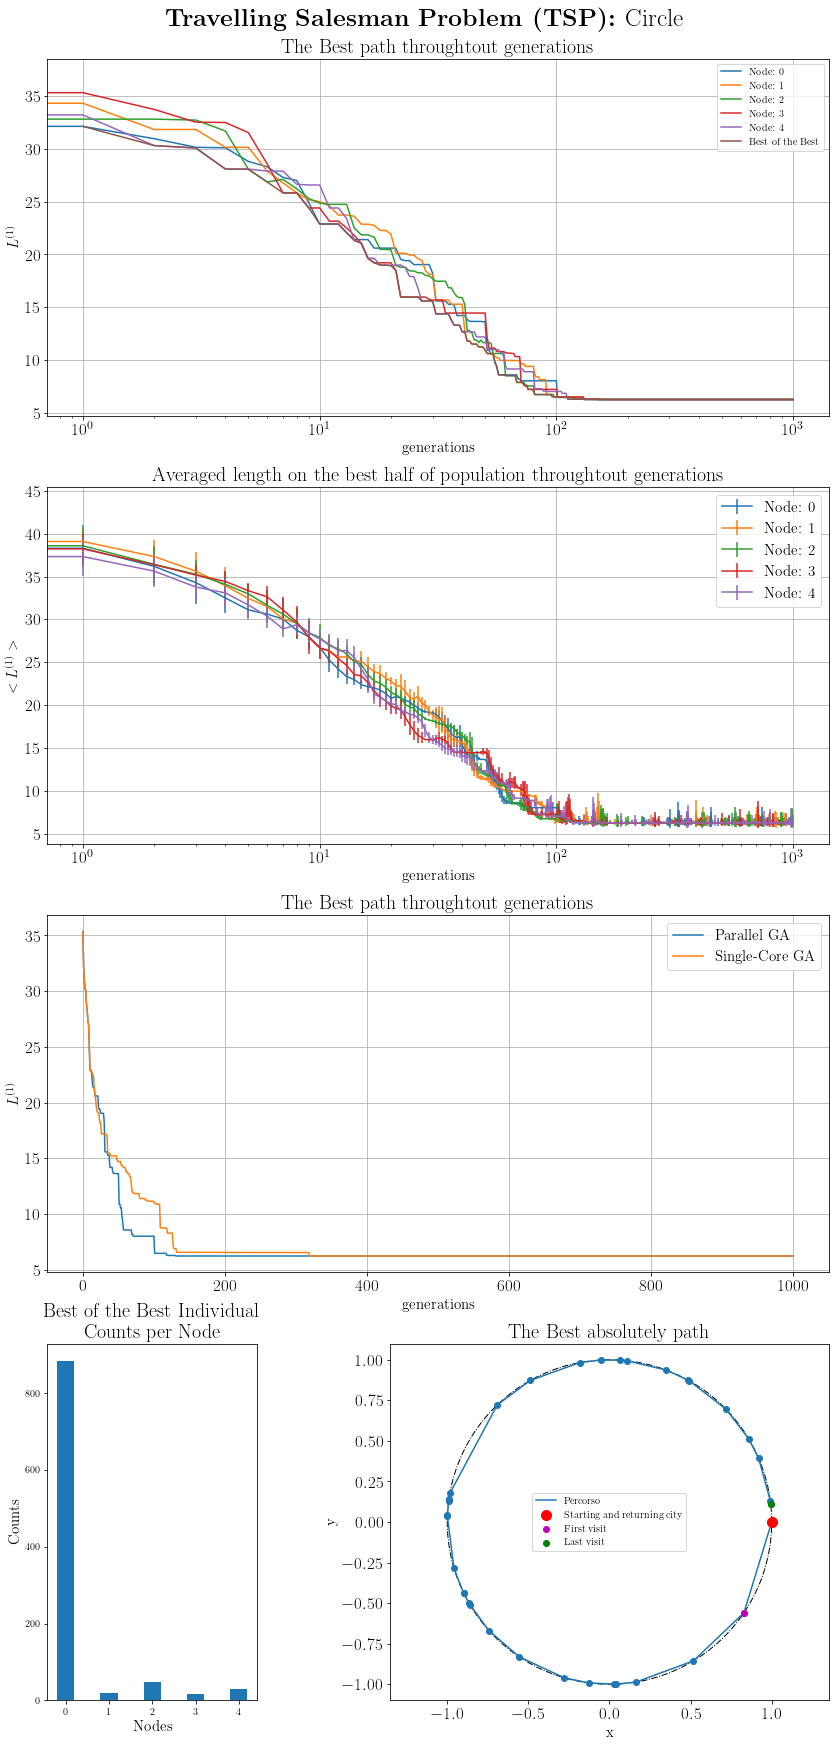

In [25]:
shape = "Circle"
path =["Es10.2/DATA/" + shape + "/Node " + str(x) + "/" for x in nodes]
nonparallel =  "../EX9/Es 9.1/DATA/" + shape + "/Best_Individual_Evolution_circle.dat"
path.append("Es10.2/DATA/" + shape + "/")

gen = np.empty(len(nodes), dtype=object)
L_best = np.empty(len(nodes), dtype=object)
L_average = np.empty(len(nodes), dtype=object)
error_L_average = np.empty(len(nodes) , dtype=object)
x_best = np.empty(len(nodes), dtype=object)
y_best = np.empty(len(nodes), dtype=object)
counts = np.zeros(len(nodes))

for i in range(len(nodes)):
    gen[i], L_best[i] = load_best_ev_data(path[i] + filenames[0] )
    gen[i] , L_average[i], error_L_average[i] = load_bestav_ev_data(path[i] + filenames[1])
    x_best[i], y_best[i] = load_best_data(path[i] + filenames[2])
    
    
bob = load_best_ev_data(path[5] + filenames[3])
L_best_NP = load_best_ev_data(nonparallel)

appo = np.loadtxt(path[5] + filenames[3], usecols=2, unpack='true')

for x in appo: 
    counts[int(x)] +=1


fig = plt.figure(figsize=(14, 24))
fig.suptitle(r"\textbf{Travelling Salesman Problem (TSP): }" + shape , fontsize=25, weight='bold')
fig.subplots_adjust(top=0.95, bottom=0.)

ax1 = plt.subplot2grid((4, 7), (0, 0), colspan=7)
ax2 = plt.subplot2grid((4, 7), (1, 0), colspan=7)
ax3 = plt.subplot2grid((4, 7), (2, 0), colspan=7)
ax4 = plt.subplot2grid((4, 7), (3, 0), colspan=2)
ax5 = plt.subplot2grid((4, 7), (3, 3), colspan=4)

for i in range(len(nodes)):
    plot_best_ev(ax1 , gen[i], L_best[i], "Node: " + str(i))
    plot_bestav_ev(ax2 , gen[i] , L_average[i] , error_L_average[i] , "Node: " + str(i))

plot_best_ev(ax1 , bob[0], bob[1], "Best of the Best")
ax1.legend()
    
plot_best_ev(ax3 , gen[0], L_best[0], "Parallel GA")
plot_best_ev(ax3 , L_best_NP[0], L_best_NP[1], "Single-Core GA")
ax3.set_xscale("linear")

ax4.bar(nodes, counts, width = 0.4)
ax4.set_xlabel('Nodes' , fontsize = 15)
ax4.set_ylabel('Counts', fontsize = 15) 
ax4.set_title(f'Best of the Best Individual \n Counts per Node' , fontsize=20)

plot_best(ax5 , x_best[int(appo[len(appo) -1 ])] , y_best[int(appo[len(appo) -1 ])] , shape)
print("The best absolute path belongs to Node: " + str(appo[len(appo) -1 ]))
print("The best absolute path is " + str(bob[1][len(bob[1]) - 1]) + " long.")

The best absolute path belongs to Node: 0.0
The best absolute path is 9.96852 long.


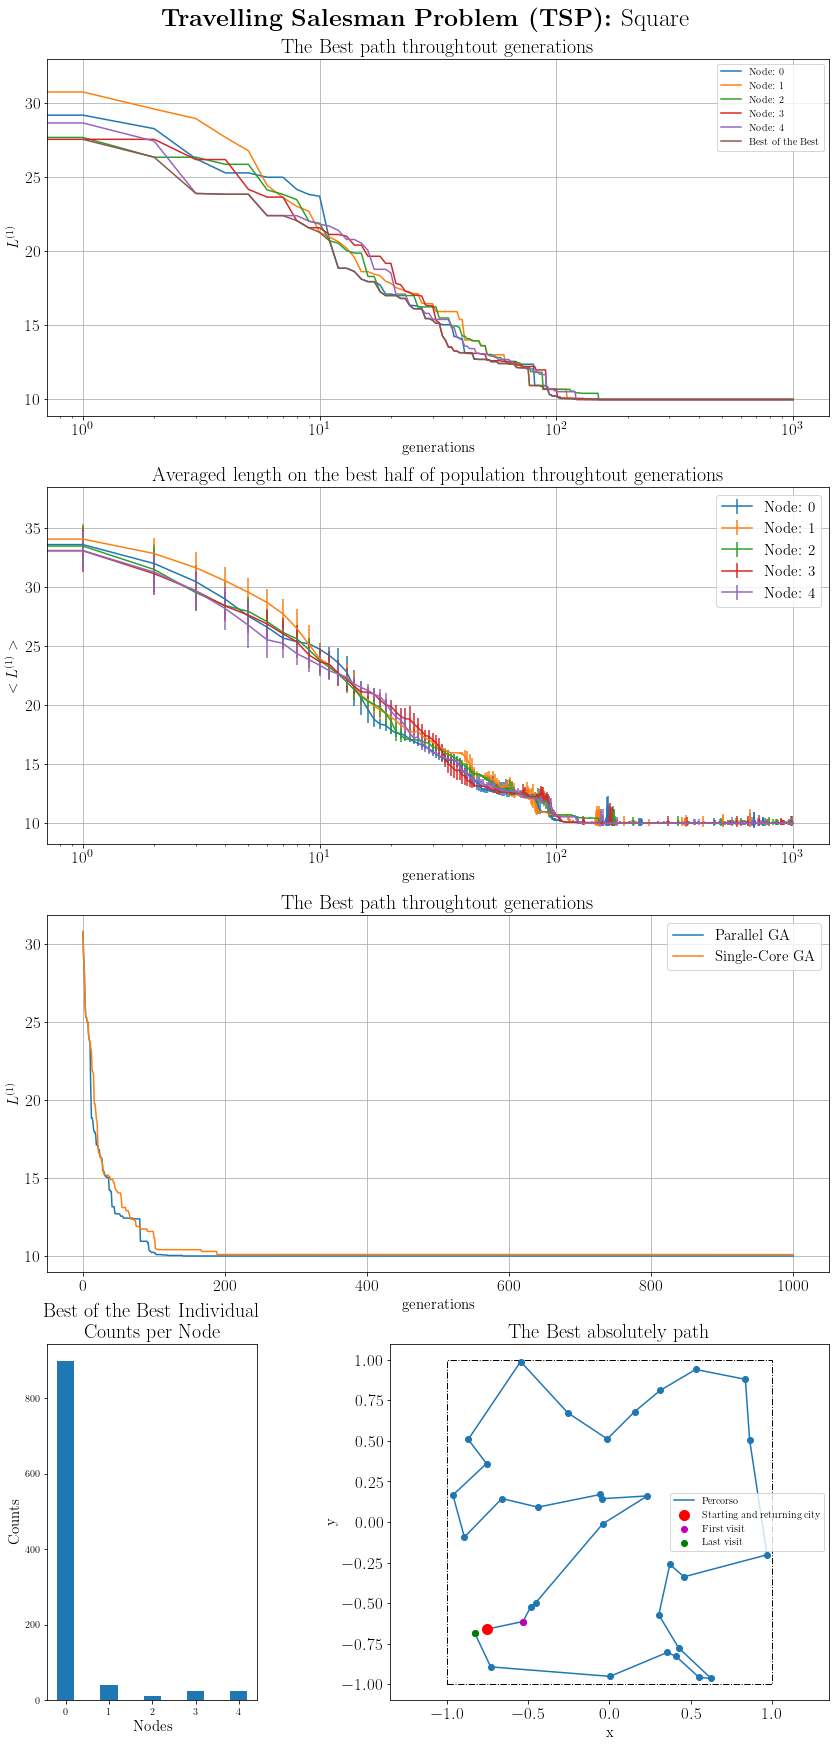

In [27]:
shape = "Square"
path =["Es10.2/DATA/" + shape + "/Node " + str(x) + "/" for x in nodes]
nonparallel =  "../EX9/Es 9.1/DATA/" + shape + "/Best_Individual_Evolution_square.dat"
path.append("Es10.2/DATA/" + shape + "/")

gen = np.empty(len(nodes), dtype=object)
L_best = np.empty(len(nodes), dtype=object)
L_average = np.empty(len(nodes), dtype=object)
error_L_average = np.empty(len(nodes) , dtype=object)
x_best = np.empty(len(nodes), dtype=object)
y_best = np.empty(len(nodes), dtype=object)
counts = np.zeros(len(nodes))

for i in range(len(nodes)):
    gen[i], L_best[i] = load_best_ev_data(path[i] + filenames[0] )
    gen[i] , L_average[i], error_L_average[i] = load_bestav_ev_data(path[i] + filenames[1])
    x_best[i], y_best[i] = load_best_data(path[i] + filenames[2])
    
    
bob = load_best_ev_data(path[5] + filenames[3])
L_best_NP = load_best_ev_data(nonparallel)

appo = np.loadtxt(path[5] + filenames[3], usecols=2, unpack='true')

for x in appo: 
    counts[int(x)] +=1


fig = plt.figure(figsize=(14, 24))
fig.suptitle(r"\textbf{Travelling Salesman Problem (TSP): }" + shape , fontsize=25, weight='bold')
fig.subplots_adjust(top=0.95, bottom=0.)

ax1 = plt.subplot2grid((4, 7), (0, 0), colspan=7)
ax2 = plt.subplot2grid((4, 7), (1, 0), colspan=7)
ax3 = plt.subplot2grid((4, 7), (2, 0), colspan=7)
ax4 = plt.subplot2grid((4, 7), (3, 0), colspan=2)
ax5 = plt.subplot2grid((4, 7), (3, 3), colspan=4)

for i in range(len(nodes)):
    plot_best_ev(ax1 , gen[i], L_best[i], "Node: " + str(i))
    plot_bestav_ev(ax2 , gen[i] , L_average[i] , error_L_average[i] , "Node: " + str(i))

plot_best_ev(ax1 , bob[0], bob[1], "Best of the Best")
ax1.legend()
    
plot_best_ev(ax3 , gen[0], L_best[0], "Parallel GA")
plot_best_ev(ax3 , L_best_NP[0], L_best_NP[1], "Single-Core GA")
ax3.set_xscale("linear")

ax4.bar(nodes, counts, width = 0.4)
ax4.set_xlabel('Nodes' , fontsize = 15)
ax4.set_ylabel('Counts', fontsize = 15) 
ax4.set_title(f'Best of the Best Individual \n Counts per Node' , fontsize=20)

plot_best(ax5 , x_best[int(appo[len(appo) -1 ])] , y_best[int(appo[len(appo) -1 ])] , shape)
print("The best absolute path belongs to Node: " + str(appo[len(appo) -1 ]))
print("The best absolute path is " + str(bob[1][len(bob[1]) - 1]) + " long.")

- Si evince dalle due simulazioni sopra riportate come il **miglioramento** in termini di **performance** del calcolo parallelo rispetto al calcolo seriale sia notevole, permettendo di raggiungere la soluzione migliore con $N_{gen}=200$ e $N_{gen}=100$ generazioni di anticipo, rispettivamente nel caso del cerchio e del quadrato
- Il grafico a barre può essere interpretato come una **misura del contributo** dei nodi alla scoperta della soluzione migliore: risulta evidente come per un calcolo così semplice, nonostante l'ottimo miglioramento delle performance, l'utilizzo di più core non sia strettamente necessario per la buona riuscita della simulazione. La maggior parte del lavoro, come si vede dal grafico, viene comunque svolta da un unico core, sufficiente, in questo caso, per trovare la soluzione esatta in un tempo di calcolo adeguato. 

The best absolute path belongs to Node: 0.0
The best absolute path is 275.458 long.


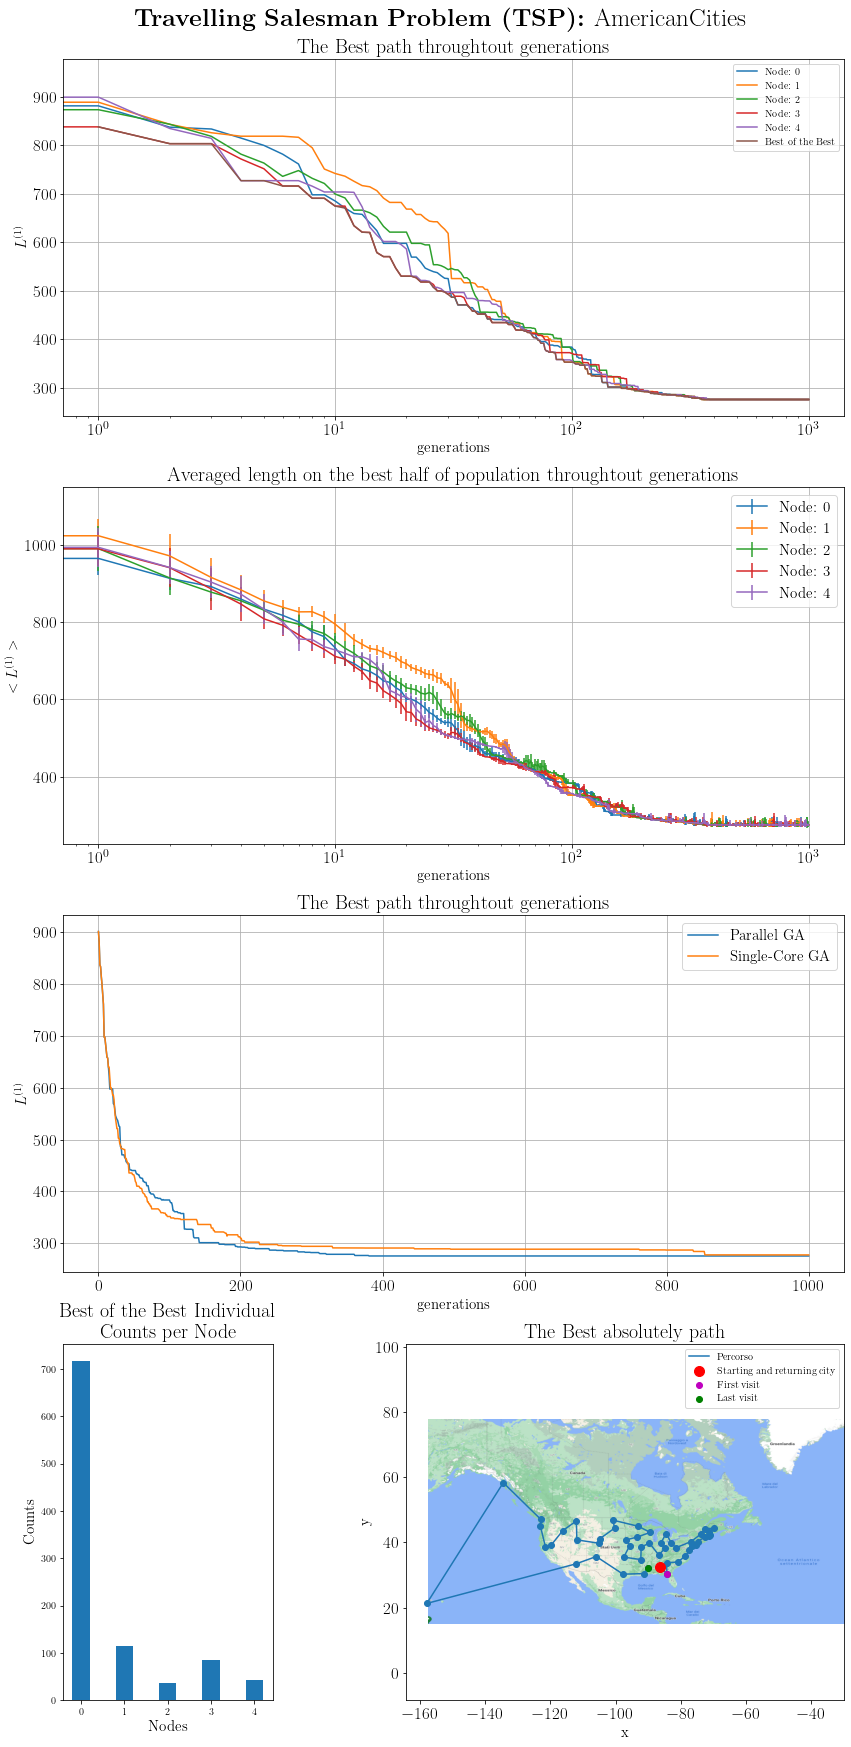

In [26]:
shape = "AmericanCities"
path =["Es10.2/DATA/" + shape + "/Node " + str(x) + "/" for x in nodes]
nonparallel =  "Es10.2/DATA/" + shape + "/Single-Core_Best_Individual_Evolution.dat"
path.append("Es10.2/DATA/" + shape + "/")

gen = np.empty(len(nodes), dtype=object)
L_best = np.empty(len(nodes), dtype=object)
L_average = np.empty(len(nodes), dtype=object)
error_L_average = np.empty(len(nodes) , dtype=object)
x_best = np.empty(len(nodes), dtype=object)
y_best = np.empty(len(nodes), dtype=object)
counts = np.zeros(len(nodes))

for i in range(len(nodes)):
    gen[i], L_best[i] = load_best_ev_data(path[i] + filenames[0] )
    gen[i] , L_average[i], error_L_average[i] = load_bestav_ev_data(path[i] + filenames[1])
    x_best[i], y_best[i] = load_best_data(path[i] + filenames[2])
    
    
bob = load_best_ev_data(path[5] + filenames[3])
L_best_NP = load_best_ev_data(nonparallel)

appo = np.loadtxt(path[5] + filenames[3], usecols=2, unpack='true')

for x in appo: 
    counts[int(x)] +=1


fig = plt.figure(figsize=(14, 24))
fig.suptitle(r"\textbf{Travelling Salesman Problem (TSP): }" + shape , fontsize=25, weight='bold')
fig.subplots_adjust(top=0.95, bottom=0.)

ax1 = plt.subplot2grid((4, 7), (0, 0), colspan=7)
ax2 = plt.subplot2grid((4, 7), (1, 0), colspan=7)
ax3 = plt.subplot2grid((4, 7), (2, 0), colspan=7)
ax4 = plt.subplot2grid((4, 7), (3, 0), colspan=2)
ax5 = plt.subplot2grid((4, 7), (3, 3), colspan=4)

for i in range(len(nodes)):
    plot_best_ev(ax1 , gen[i], L_best[i], "Node: " + str(i))
    plot_bestav_ev(ax2 , gen[i] , L_average[i] , error_L_average[i] , "Node: " + str(i))

plot_best_ev(ax1 , bob[0], bob[1], "Best of the Best")
ax1.legend()
    
plot_best_ev(ax3 , gen[0], L_best[0], "Parallel GA")
plot_best_ev(ax3 , L_best_NP[0], L_best_NP[1], "Single-Core GA")
ax3.set_xscale("linear")

ax4.bar(nodes, counts, width = 0.4)
ax4.set_xlabel('Nodes' , fontsize = 15)
ax4.set_ylabel('Counts', fontsize = 15) 
ax4.set_title(f'Best of the Best Individual \n Counts per Node' , fontsize=20)

plot_best(ax5 , x_best[int(appo[len(appo) -1 ])] , y_best[int(appo[len(appo) -1 ])] , shape)
print("The best absolute path belongs to Node: " + str(appo[len(appo) -1 ]))
print("The best absolute path is " + str(bob[1][len(bob[1]) - 1]) + " long.")

- Nel caso delle 50 città (dato che $50! >> 30!$) il problema risulta molto più complesso. Dal plot dell'andamento della funzione costo e dal grafico a barre si deduce come il contributo dei core multipli giochi un ruolo **maggiormente rilevante** nelle performance dell'algoritmo, permettendo di raggiungere la soluzione con $N_{gen}=500$ generazioni di anticipo. Il grafico a barre conferma che l'importanza dei diversi core è aumentata, dato che ognuno di essi contribuisce in modo più rilevante alla ricerca del percorso migliore.